# The Battle of the Neighborhood - Week 2

## Importing libraries

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from pandas.io.json import json_normalize

## Preparing the datas

In [234]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
tables = pd.read_html(url)
df = tables[0] # As two tables on the link, this is the first.
df.head(3)

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods


#### Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [235]:
#Getting the index to drop the rows
index_to_drop = df[df['Borough'] == 'Not assigned'].index
#Droping row with the filtered index
df.drop(index_to_drop, inplace=True)
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


#### If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough

In [236]:
df.loc[df['Neighborhood'] == 'Not assigned','Neighborhood'] = df['Borough']
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [237]:
df.shape

(103, 3)

## Doing a merge with the Data 2

In [238]:
!wget -q -O 'Toronto_long_lat_data.csv'  http://cocl.us/Geospatial_data
df_long_lat = pd.read_csv('Toronto_long_lat_data.csv')
df_long_lat.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [239]:
df_toronto = pd.merge(df,df_long_lat)
df_toronto.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## Importing libraries to explore geopoints in toronto to find restaurants and respective categories

In [240]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [241]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [242]:
CLIENT_ID = 'V5VLZI2EODITT2CIS1PBPGEOJIPQOZMNHAY103CYIOATSSHR' # your Foursquare ID
CLIENT_SECRET = 'MIU2NBWKFZBWGLPTF03G1VAINJ2TSFL1ZMXKHYTJ3CTPQHJN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: V5VLZI2EODITT2CIS1PBPGEOJIPQOZMNHAY103CYIOATSSHR
CLIENT_SECRET:MIU2NBWKFZBWGLPTF03G1VAINJ2TSFL1ZMXKHYTJ3CTPQHJN


In [243]:
# defining radius and limit of venues to get
radius=1000
LIMIT=1000
japanese='Japanese'
chinese='Chinese'
brazilian='Brazilian'
italian='Italian'
arabic='Arabic'
mexican='Mexican'
canadian='Canadian'
american='American'
indian='Indian'
english='English'

In [244]:
def get_df_categorie(search_query,latitude,longitude,radius):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    df = json_normalize(results['response']['venues'])
    return df

In [245]:
df_japanese = get_df_categorie(japanese,latitude,longitude,radius)
df_chinese = get_df_categorie(chinese,latitude,longitude,radius)
df_brazilian = get_df_categorie(brazilian,latitude,longitude,radius)
df_italian = get_df_categorie(italian,latitude,longitude,radius)
df_arabic = get_df_categorie(arabic,latitude,longitude,radius)
df_mexican = get_df_categorie(mexican,latitude,longitude,radius)
df_canadian = get_df_categorie(canadian,latitude,longitude,radius)
df_american = get_df_categorie(american,latitude,longitude,radius)
df_indian = get_df_categorie(indian,latitude,longitude,radius)
df_english = get_df_categorie(english,latitude,longitude,radius)
array_lenghs = [len(df_japanese),len(df_chinese),len(df_brazilian),len(df_italian),len(df_arabic),len(df_mexican),len(df_canadian),len(df_american),len(df_indian),len(df_english)]
array_lenghs

[23, 22, 2, 16, 0, 12, 50, 13, 16, 2]

## Plot of the quantity of restaurants categories in Toronto

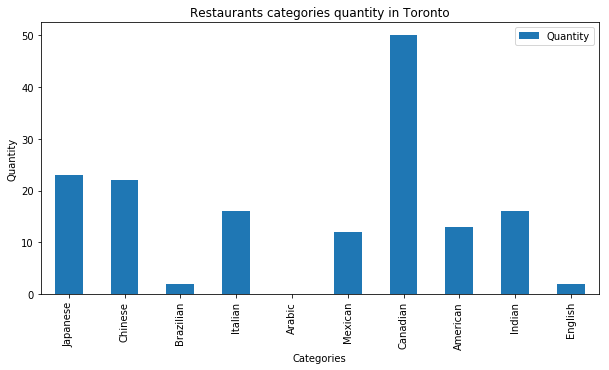

In [246]:
d = {'Japanese': array_lenghs[0], 'Chinese': array_lenghs[1],'Brazilian': array_lenghs[2] ,'Italian':array_lenghs[3] ,'Arabic': array_lenghs[4],'Mexican':array_lenghs[5],
    'Canadian': array_lenghs[6],'American': array_lenghs[7],'Indian': array_lenghs[8],'English': array_lenghs[9]}
df_categoires = pd.DataFrame(d,index=['Quantity'])
df_categoires.T.plot(kind='bar',figsize=(10,5))
plt.xlabel('Categories')
plt.ylabel('Quantity')
plt.title('Restaurants categories quantity in Toronto')
plt.show()

### Filtering relevants arguments

In [247]:
# keep only columns that include venue name, and anything that is associated with location
def get_filtered_df(dataframe):
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']

        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

    return dataframe_filtered

df_brazilian_filtered = get_filtered_df(df_brazilian)
df_japanese_filtered = get_filtered_df(df_japanese)
df_chinese_filtered = get_filtered_df(df_chinese)
# df_arabic_filtered = get_filtered_df(df_arabic) don't have ARABIC foods in toronto
df_italian_filtered = get_filtered_df(df_italian)
df_indian_filtered = get_filtered_df(df_indian)
df_mexican_filtered = get_filtered_df(df_mexican)
df_american_filtered = get_filtered_df(df_american)

## Plotting the restaurants in the map

In [248]:
toronto_map = folium.Map(location=[latitude,longitude],zoom_start=15)

# add a red circle marker to represent center of Toronto
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Conrad Hotel',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(toronto_map)

# add the Brazilian restaurants as blue circle markers
for lat, lng, label in zip(df_brazilian_filtered.lat, df_brazilian_filtered.lng, df_brazilian_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(toronto_map)
    
# add the Japanese restaurants as blue circle markers
for lat, lng, label in zip(df_japanese_filtered.lat, df_japanese_filtered.lng, df_japanese_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(toronto_map)

# add the Chinese restaurants as blue circle markers
for lat, lng, label in zip(df_chinese_filtered.lat, df_chinese_filtered.lng, df_chinese_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='yellow',
        popup=label,
        fill = True,
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(toronto_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(df_italian_filtered.lat, df_italian_filtered.lng, df_italian_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='purple',
        popup=label,
        fill = True,
        fill_color='purple',
        fill_opacity=0.6
    ).add_to(toronto_map)
    
# add the Mexican restaurants as blue circle markers
for lat, lng, label in zip(df_mexican_filtered.lat, df_mexican_filtered.lng, df_mexican_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='orange',
        popup=label,
        fill = True,
        fill_color='orange',
        fill_opacity=0.6
    ).add_to(toronto_map)
    
# add the Indian restaurants as blue circle markers
for lat, lng, label in zip(df_indian_filtered.lat, df_indian_filtered.lng, df_indian_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blueviolet',
        popup=label,
        fill = True,
        fill_color='blueviolet',
        fill_opacity=0.6
    ).add_to(toronto_map)

# add the American restaurants as blue circle markers
for lat, lng, label in zip(df_american_filtered.lat, df_american_filtered.lng, df_american_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='deeppink',
        popup=label,
        fill = True,
        fill_color='deeppink',
        fill_opacity=0.6
    ).add_to(toronto_map)
    
toronto_map